# GPON Network visualizations - Final Part (4)

## Final visualization

For the final visualization I want to delve into the FTTx __optical distribution network__ (ODN), and more specifically, to visualize the relationship of the received optical power of an ONT, and the distance to said ONT to its serving PON port. 

To help in this visualization I want to use a fusion of two plots, a scatter plot, and some histograms, and I will use an example from [this matplotlib example page](https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html).

To get some context, the ODN is used to distribute the optical signal from the OLT PON port, to the final client's ONT (Optical Network Terminal) device, which allows the customer to enjoy triple play services at their homes, you can see a simple diagram  [from Wikipedia](https://commons.wikimedia.org/wiki/File:GPON_topology.png):


![FTTx ODN simple diagram](GPON_topology_wikipedia.png "FTTx ODN simple diagram")


As you can see, the main components of the ODN are optical fiber cables, and optical splitters, which are passive optical devices, and that means that they attenuate the optical signal that traverse them, both due to very complex physical phenomena which we will not discuss here. And is this attenuation, a very important KPI in the GPON/FTTx networks, the main subject of today's visualization, although we will use a proxy to it: the received (Rx) optical power, because if this parameter is very low in the network, the final customers won't be able to enjoy their services. The main goal of this article is not to explain the reasons why this phenomena happens, nor how to manage it, but, as I stated above, to be able to visualize the relationship of between the distance of an ONT, and its receiving optical power. There are plenty of resources on the internet about this phenomena, if you are more interested in it, you can refer to them.

To make our discussion and plot more interesting, I will introduce a Rx optical power threshold of -22 dBm, and this means, that if an ONT in the ODN has an Rx optical power below this threshold, the customer won't be able to have an enjoyable experience with their services. And to make this threshold visible, all the Rx optical samples that are above it, will be colored "green", and all the other samples below it, will be colored in "red".


## The data needed

To do a scatter plot we need two variables, and in our case, we need a variable to represent the distance, and another to represent the receiving optical power, and as before, lets create our synthetic ones with the help of "scipy" library:

In [1]:
# Make all the imports needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, skewnorm
import math

The parameters for the distance (skewed normal variable) variable will be:

* "a": Indicating the "skewness" of the distribution.
* "loc": Here we can safely say that it acts as an overall average, measured in meters.
* "scale": Also safe to say that it acts as a standard deviation of the whole distribution.
* "size": Its the quantity of points (ONTs) we want our random variable to have, measured in quantity of ONTs.

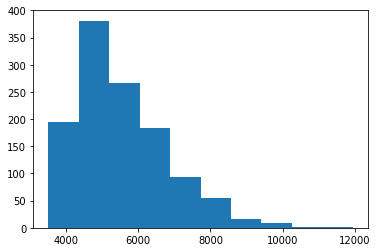

In [2]:
a = 10
loc = 4000
scale = 2000
size = 1200
distance = skewnorm.rvs(a, loc, scale, size, random_state=28)
plt.hist(np.sort(distance))
plt.show()

And in the histogram of the variable we can see its tail is more heavy to the right side of the distribution.


The parameters for the optical received power (normal variable) variable will be:

* "loc": Here we can safely say that it acts as an average for the distribution, measured in DBm ([Decibels-mili](hhttps://en.wikipedia.org/wiki/DBm)).
* "scale": Also safe to say that it acts as a standard deviation of the distribution.
* "size": Its the quantity of points (ONTs) we want our random variable to have, measured in quantity of ONTs.

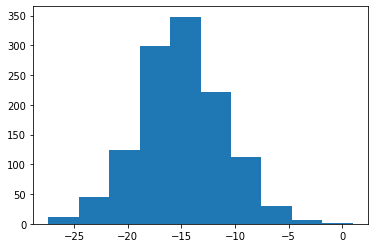

In [3]:
loc = -15
scale = 4
size = 1200
optical_power = norm.rvs(loc, scale, size, random_state=28)
plt.hist(np.sort(optical_power))
plt.show()

Now let's create our synthetic dataset, we put it all together and have the following:

In [4]:
data_df = pd.DataFrame([distance, np.sort(optical_power)])
data_df = data_df.T
data_df.rename(columns={0:'distance', 1:'optical_power'}, inplace=True)
#data_df['avg_speed'] = data_df['throughput'].divide(data_df['client_qty'])
data_df

,distance,optical_power
0,4876.331154,-27.385335
1,7432.117271,-26.509691
2,4514.882350,-26.497177
3,6041.648544,-26.229848
4,3985.629577,-25.153075
...,...,...
1195,6501.757434,-3.123880
1196,6747.457564,-3.072417
1197,3746.900394,-2.839726
1198,6201.993376,-2.718628


After that we obtain a Pandas dataframe with 1200 rows, representing each individual ONT that belong to a single OLT, with two columns: __distance,	optical power__, which should be self explanatory.

## Create the visualization

This time I'm doing it inside a function (which I recommend doing for the other all the visualizations you'll do), and I'll put comments for each block of code. It is also useful to remember this plot is from an example from the Matplotlib library documentation page, so some of the parameters and conventions are from that particular example:

In [5]:
def double_hist_and_scatter_plot(df):  

    # Auxilliary parameters for the plot, number of bins
    w = 2
    n = math.ceil((df['optical_power'].max() - df['optical_power'].min()) / w)

    # definitions for the axes limits and positions
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    # Ranges for the optical receiving power. This will allow us to separate the "good" samples
    # from "critical" ones.
    normal_range = [0.0, -21.9]
    critical_range = [-22.0, -40]
    
    # Colors for the ranges, green for the "good" ones, and red for the "bad" ones
    normal_color = 'green'
    critical_color = 'red'

    # Lists of the ranges, to be able to iterate through them
    ranges = [normal_range, critical_range]
    colors = [normal_color, critical_color]

    # X axis values, in this case are the distances
    exes = []
    for range in ranges:
        x = df[(df['optical_power'] <= range[0]) & (df['optical_power'] >= range[1])]['distance']
        exes.append(x)
    
    # Y axis values for the plot, in this case are the Rx optical powers
        yses = []
        for range in ranges:
            y = df[(df['optical_power'] <= range[0]) & (df['optical_power'] >= range[1])]['optical_power']
            yses.append(y)

    # start with a rectangular Figure
    plt.figure(figsize=(30, 10))   

    # Creation of the axes, and some parameters for the plot
    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True, labelsize=20)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False, labelsize=20)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False, labelsize=20, labelrotation=45)

    # the scatter plot:
    for (x, y, color) in zip(exes, yses, colors):
        ax_scatter.scatter(x, y, alpha=0.5, color= color)

    ax_scatter.set_xlabel('Distance (m)', fontsize=30)
    ax_scatter.set_ylabel('RX optical power (dBm)', fontsize=30)
    # Plot the threshold line
    ax_scatter.axhline(critical_range[0], color='red', lw=6)

    # The histogram plots, only for the power we will use color ranges, for the distance no
    for (x, y, color) in zip(exes, yses, colors):
        ax_histy.hist(y, bins=n, orientation='horizontal', color=color)
    ax_histx.hist(x, bins=n, color='green')
    plt.show()

    # Table creation
    bins = ['Optimal', 'Critical']
    data = []
    for y in yses:
        data.append(y.count())
    
    table = pd.DataFrame(list(zip(bins, data)), columns=['Ranges', 'Quantity'])
    print(table.head(5))

Now, we call the our function to make the plot, with the data as parameter:

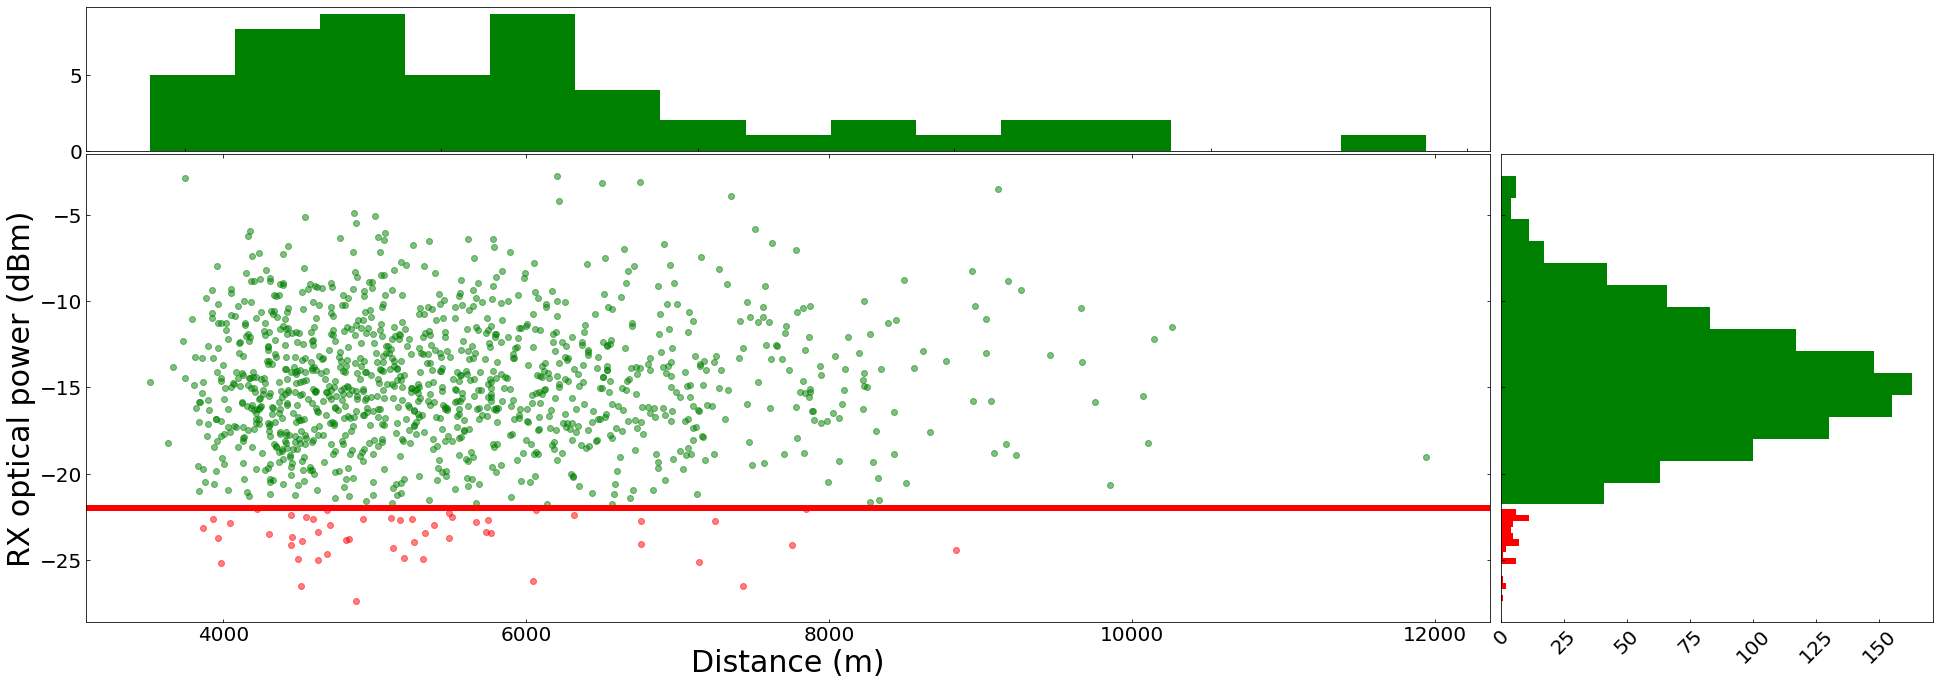

     Ranges  Quantity
0   Optimal      1146
1  Critical        51


In [6]:
double_hist_and_scatter_plot(data_df)

## Closing comments

* Surprisingly enough, this plot looks almost identical to a real one.
* This plot has many, many layers, and touch many, many areas of the FTTx ODN deployment projects, so I'll try and be as precise and concise as I can, yet there sure will be topic that I won't be able to touch on.
* We chose the threshold of -22 dBm for the Rx optical power as critical to have a more interesting visualization, as I stated above, but this threshold varies from deployment to deployment, and also is influenced by many FTTx deployment decisions, like: ODN splitting scheme, max quantity of clients per PON port, optical fiber type, Quality Assurance personnel experience and critiria, and many, many more, so of course you will use your own threshold.
* This plot will help you in many ways:
    - You'll be able to visualize in a quick way how healthy is your ODN. I recommend doing this plot globally, per macro-geographical region, per CO (central office), and per OLT.
    - You'll be able to check very quickly if certain level of you ODN is in optical quality trouble.
    - If you add contractor data (as contractor name) and filter per contractor, you'll be able to asses which contractors have a higher quality practices, and which don't. I don't recommend using this to punish contractors, but to anticipate their finished product quality performance, and decide where you want higher quality standards, and assign those contractors to those areas in your deployment.
* You can start to track this KPIs, weekly, or monthly, and try to lower them. Though the latter is easier said, than done, this is a way to start.
* Generally this plot tells us that, it is the last mile operations personnel that cause the most drop in performance in the ODN's last mile KPIs, because there shouldn't be any low Rx power in short distance ONTs.
* I'm sure you will be able to see many more amazing insights from this plot, and you'll find new ways to incorporate it to your quality assurance process.

I hope this was useful for you, and that you are looking forward for the next visualization!
